In [86]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 50

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [104]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.1)
        self.fc2 = Linear(36, 4)
        self.fc3 = Linear(4, 1)

        # Quantum layer
        self.num_q_wires = 4
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 2
        qnn_params_size = (self.num_q_layers * 3 + 2) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RZ(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRZ(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    qml.RX(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                    #param_idx += 2
                    qml.Y(wires=i)

                for i in range(self.num_q_wires//2):
                    #qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    #param_idx += 1
                    #qml.CNOT(wires=[i, (i+1)%self.num_q_wires])
                    qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    param_idx += 1
                    qml.CRX(self.qnn_params[param_idx], wires=[i+2, (i+3)%self.num_q_wires])
                    param_idx += 1


                #for i in range(self.num_q_wires):
                #    qml.Z(wires=i)
                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        qml.RX(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                        #param_idx += 2
                        qml.Y(wires=i)
            
            #return qml.expval(self.obs) # qml.expval은 이제 (BATCH_SIZE,) 형태를 반환
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        #x = F.silu(self.conv1(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        #x = F.silu(self.conv2(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.silu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=36, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

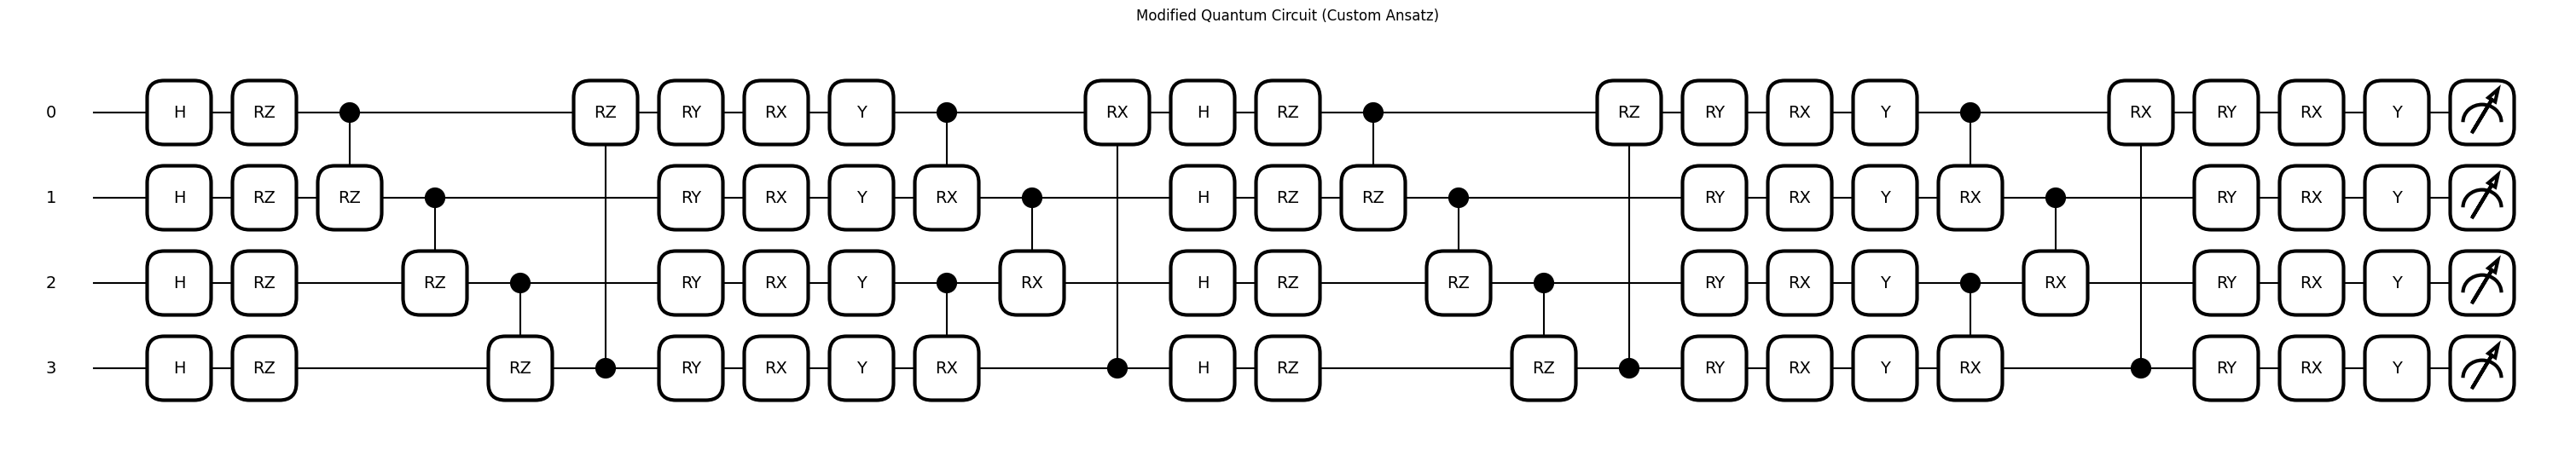

In [105]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [106]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 4,
 'num_observables': 4,
 'num_tape_wires': 4,
 'num_trainable_params': 32,
 'resources': Resources(num_wires=4,
                        num_gates=68,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CRX': 8,
                                                'CRZ': 8,
                                                'Hadamard': 8,
                                                'PauliY': 12,
                                                'RX': 12,
                                                'RY': 12,
                                                'RZ': 8}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 52,
                                                2: 16}),
     

In [107]:
def train_step(epochs=10, lr=0.0010, weight_decay=1e-6):
    optimizer = AdamW(bc.parameters(), lr=lr, weight_decay=weight_decay)
    #optimizer = RAdam(bc.parameters(), lr=lr, weight_decay=weight_decay)
    # RAdam은 별로 성능 향상을 보이지 않음
    loss_func  = NLLLoss()

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()


    print(f"Starting training on {device}...")
    for epoch in range(epochs):
        epoch_bar = tqdm(enumerate(train_loader),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        total=len(train_loader),
                        leave=True)

        total_loss = []
        for bidx, (data, target) in epoch_bar:
            data = data.to(device)
            target = target.to(device).flatten().long()
            #target = target.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)

            output = bc(data)
            loss = loss_func(output, target)

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            if bidx % 100 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}",
                                    lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")
        
    return loss_history


In [108]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [109]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [110]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 10
lr = 0.0015
loss_history = []

while result < 0.92:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:21<00:00, 11.34it/s, batch=200, loss=0.3623, lr=0.001474]


Training [10%] Loss: 0.4596


Epoch 2/10: 100%|██████████| 240/240 [00:21<00:00, 11.00it/s, batch=200, loss=0.2521, lr=0.001379]


Training [20%] Loss: 0.3544


Epoch 3/10: 100%|██████████| 240/240 [00:24<00:00,  9.79it/s, batch=200, loss=0.3438, lr=0.001221]


Training [30%] Loss: 0.3133


Epoch 4/10: 100%|██████████| 240/240 [00:23<00:00, 10.08it/s, batch=200, loss=0.3212, lr=0.001018]


Training [40%] Loss: 0.2949


Epoch 5/10: 100%|██████████| 240/240 [00:22<00:00, 10.90it/s, batch=200, loss=0.2745, lr=0.000789]


Training [50%] Loss: 0.2749


Epoch 6/10: 100%|██████████| 240/240 [00:21<00:00, 11.40it/s, batch=200, loss=0.2596, lr=0.000556]


Training [60%] Loss: 0.2542


Epoch 7/10: 100%|██████████| 240/240 [00:20<00:00, 11.80it/s, batch=200, loss=0.1432, lr=0.000341]


Training [70%] Loss: 0.2431


Epoch 8/10: 100%|██████████| 240/240 [00:20<00:00, 11.65it/s, batch=200, loss=0.1677, lr=0.000167]


Training [80%] Loss: 0.2303


Epoch 9/10: 100%|██████████| 240/240 [00:20<00:00, 11.67it/s, batch=200, loss=0.2905, lr=0.000050]


Training [90%] Loss: 0.2251


Epoch 10/10: 100%|██████████| 240/240 [00:20<00:00, 11.66it/s, batch=200, loss=0.2896, lr=0.000002]


Training [100%] Loss: 0.2225
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8845
Iteration 1: Result = 0.8845
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:20<00:00, 11.52it/s, batch=200, loss=0.3347, lr=0.001179]


Training [10%] Loss: 0.2505


Epoch 2/10: 100%|██████████| 240/240 [00:21<00:00, 11.21it/s, batch=200, loss=0.2383, lr=0.001103]


Training [20%] Loss: 0.2464


Epoch 3/10: 100%|██████████| 240/240 [00:20<00:00, 11.95it/s, batch=200, loss=0.2243, lr=0.000977]


Training [30%] Loss: 0.2365


Epoch 4/10: 100%|██████████| 240/240 [00:20<00:00, 11.83it/s, batch=200, loss=0.3278, lr=0.000815]


Training [40%] Loss: 0.2210


Epoch 5/10: 100%|██████████| 240/240 [00:19<00:00, 12.02it/s, batch=200, loss=0.1638, lr=0.000631]


Training [50%] Loss: 0.2175


Epoch 6/10: 100%|██████████| 240/240 [00:19<00:00, 12.19it/s, batch=200, loss=0.2348, lr=0.000445]


Training [60%] Loss: 0.2061


Epoch 7/10: 100%|██████████| 240/240 [00:20<00:00, 11.91it/s, batch=200, loss=0.3522, lr=0.000273]


Training [70%] Loss: 0.1872


Epoch 8/10: 100%|██████████| 240/240 [00:20<00:00, 11.97it/s, batch=200, loss=0.1186, lr=0.000134]


Training [80%] Loss: 0.1833


Epoch 9/10: 100%|██████████| 240/240 [00:20<00:00, 11.98it/s, batch=200, loss=0.1770, lr=0.000041]


Training [90%] Loss: 0.1800


Epoch 10/10: 100%|██████████| 240/240 [00:20<00:00, 11.93it/s, batch=200, loss=0.2071, lr=0.000002]


Training [100%] Loss: 0.1755
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8890
Iteration 2: Result = 0.8890
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:20<00:00, 11.80it/s, batch=200, loss=0.2002, lr=0.000943]


Training [10%] Loss: 0.2098


Epoch 2/10: 100%|██████████| 240/240 [00:20<00:00, 11.88it/s, batch=200, loss=0.1961, lr=0.000882]


Training [20%] Loss: 0.2033


Epoch 3/10: 100%|██████████| 240/240 [00:21<00:00, 11.06it/s, batch=200, loss=0.2180, lr=0.000782]


Training [30%] Loss: 0.1988


Epoch 4/10: 100%|██████████| 240/240 [00:23<00:00, 10.15it/s, batch=200, loss=0.2567, lr=0.000652]


Training [40%] Loss: 0.1931


Epoch 5/10: 100%|██████████| 240/240 [00:23<00:00, 10.32it/s, batch=200, loss=0.1156, lr=0.000505]


Training [50%] Loss: 0.1861


Epoch 6/10: 100%|██████████| 240/240 [00:23<00:00, 10.22it/s, batch=200, loss=0.1432, lr=0.000356]


Training [60%] Loss: 0.1745


Epoch 7/10: 100%|██████████| 240/240 [00:23<00:00, 10.20it/s, batch=200, loss=0.0673, lr=0.000219]


Training [70%] Loss: 0.1650


Epoch 8/10: 100%|██████████| 240/240 [00:21<00:00, 10.98it/s, batch=200, loss=0.1688, lr=0.000107]


Training [80%] Loss: 0.1563


Epoch 9/10: 100%|██████████| 240/240 [00:22<00:00, 10.78it/s, batch=200, loss=0.1786, lr=0.000033]


Training [90%] Loss: 0.1525


Epoch 10/10: 100%|██████████| 240/240 [00:18<00:00, 12.78it/s, batch=200, loss=0.1391, lr=0.000002]


Training [100%] Loss: 0.1498
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8925
Iteration 3: Result = 0.8925
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:18<00:00, 12.87it/s, batch=200, loss=0.1040, lr=0.000755]


Training [10%] Loss: 0.1806


Epoch 2/10: 100%|██████████| 240/240 [00:22<00:00, 10.77it/s, batch=200, loss=0.3491, lr=0.000706]


Training [20%] Loss: 0.1779


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 13.11it/s, batch=200, loss=0.2167, lr=0.000625]


Training [30%] Loss: 0.1733


Epoch 4/10: 100%|██████████| 240/240 [00:18<00:00, 12.74it/s, batch=200, loss=0.1484, lr=0.000521]


Training [40%] Loss: 0.1644


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.02it/s, batch=200, loss=0.0502, lr=0.000404]


Training [50%] Loss: 0.1528


Epoch 6/10: 100%|██████████| 240/240 [00:18<00:00, 13.27it/s, batch=200, loss=0.1833, lr=0.000285]


Training [60%] Loss: 0.1482


Epoch 7/10: 100%|██████████| 240/240 [00:17<00:00, 13.52it/s, batch=200, loss=0.0775, lr=0.000175]


Training [70%] Loss: 0.1399


Epoch 8/10: 100%|██████████| 240/240 [00:18<00:00, 13.27it/s, batch=200, loss=0.1975, lr=0.000086]


Training [80%] Loss: 0.1299


Epoch 9/10: 100%|██████████| 240/240 [00:17<00:00, 13.45it/s, batch=200, loss=0.1853, lr=0.000026]


Training [90%] Loss: 0.1277


Epoch 10/10: 100%|██████████| 240/240 [00:18<00:00, 13.11it/s, batch=200, loss=0.1250, lr=0.000001]


Training [100%] Loss: 0.1300
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8890
Iteration 4: Result = 0.8890
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:18<00:00, 12.98it/s, batch=200, loss=0.1256, lr=0.000604]


Training [10%] Loss: 0.1513


Epoch 2/10: 100%|██████████| 240/240 [00:18<00:00, 13.13it/s, batch=200, loss=0.1483, lr=0.000565]


Training [20%] Loss: 0.1509


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 13.23it/s, batch=200, loss=0.1150, lr=0.000500]


Training [30%] Loss: 0.1471


Epoch 4/10: 100%|██████████| 240/240 [00:18<00:00, 13.15it/s, batch=200, loss=0.1312, lr=0.000417]


Training [40%] Loss: 0.1438


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.21it/s, batch=200, loss=0.0575, lr=0.000323]


Training [50%] Loss: 0.1370


Epoch 6/10: 100%|██████████| 240/240 [00:18<00:00, 13.16it/s, batch=200, loss=0.1317, lr=0.000228]


Training [60%] Loss: 0.1314


Epoch 7/10: 100%|██████████| 240/240 [00:18<00:00, 13.14it/s, batch=200, loss=0.1118, lr=0.000140]


Training [70%] Loss: 0.1200


Epoch 8/10: 100%|██████████| 240/240 [00:18<00:00, 13.12it/s, batch=200, loss=0.0687, lr=0.000069]


Training [80%] Loss: 0.1164


Epoch 9/10: 100%|██████████| 240/240 [00:19<00:00, 12.40it/s, batch=200, loss=0.0697, lr=0.000021]


Training [90%] Loss: 0.1103


Epoch 10/10: 100%|██████████| 240/240 [00:18<00:00, 12.78it/s, batch=200, loss=0.1060, lr=0.000001]


Training [100%] Loss: 0.1147
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8865
Iteration 5: Result = 0.8865
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:18<00:00, 12.96it/s, batch=200, loss=0.0986, lr=0.000483]


Training [10%] Loss: 0.1350


Epoch 2/10: 100%|██████████| 240/240 [00:18<00:00, 13.17it/s, batch=200, loss=0.0591, lr=0.000452]


Training [20%] Loss: 0.1290


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 13.19it/s, batch=200, loss=0.1761, lr=0.000400]


Training [30%] Loss: 0.1233


Epoch 4/10: 100%|██████████| 240/240 [00:18<00:00, 13.14it/s, batch=200, loss=0.0589, lr=0.000334]


Training [40%] Loss: 0.1245


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.23it/s, batch=200, loss=0.0486, lr=0.000259]


Training [50%] Loss: 0.1224


Epoch 6/10: 100%|██████████| 240/240 [00:18<00:00, 13.09it/s, batch=200, loss=0.0801, lr=0.000182]


Training [60%] Loss: 0.1133


Epoch 7/10: 100%|██████████| 240/240 [00:18<00:00, 13.14it/s, batch=200, loss=0.0361, lr=0.000112]


Training [70%] Loss: 0.1095


Epoch 8/10: 100%|██████████| 240/240 [00:18<00:00, 13.05it/s, batch=200, loss=0.0410, lr=0.000055]


Training [80%] Loss: 0.1045


Epoch 9/10: 100%|██████████| 240/240 [00:18<00:00, 13.18it/s, batch=200, loss=0.1192, lr=0.000017]


Training [90%] Loss: 0.1072


Epoch 10/10: 100%|██████████| 240/240 [00:18<00:00, 13.19it/s, batch=200, loss=0.0946, lr=0.000001]


Training [100%] Loss: 0.1051
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8875
Iteration 6: Result = 0.8875
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:18<00:00, 13.15it/s, batch=200, loss=0.1369, lr=0.000386]


Training [10%] Loss: 0.1215


Epoch 2/10: 100%|██████████| 240/240 [00:18<00:00, 12.89it/s, batch=200, loss=0.0804, lr=0.000361]


Training [20%] Loss: 0.1183


Epoch 3/10: 100%|██████████| 240/240 [00:19<00:00, 12.53it/s, batch=200, loss=0.0477, lr=0.000320]


Training [30%] Loss: 0.1077


Epoch 4/10: 100%|██████████| 240/240 [00:18<00:00, 13.21it/s, batch=200, loss=0.1123, lr=0.000267]


Training [40%] Loss: 0.1087


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.22it/s, batch=200, loss=0.1472, lr=0.000207]


Training [50%] Loss: 0.1088


Epoch 6/10: 100%|██████████| 240/240 [00:18<00:00, 13.29it/s, batch=200, loss=0.0391, lr=0.000146]


Training [60%] Loss: 0.1049


Epoch 7/10: 100%|██████████| 240/240 [00:18<00:00, 13.21it/s, batch=200, loss=0.2275, lr=0.000090]


Training [70%] Loss: 0.0994


Epoch 8/10: 100%|██████████| 240/240 [00:18<00:00, 13.12it/s, batch=200, loss=0.1491, lr=0.000045]


Training [80%] Loss: 0.0937


Epoch 9/10: 100%|██████████| 240/240 [00:19<00:00, 12.17it/s, batch=200, loss=0.1164, lr=0.000014]


Training [90%] Loss: 0.0922


Epoch 10/10: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.1982, lr=0.000001]


Training [100%] Loss: 0.1010
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8880
Iteration 7: Result = 0.8880
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:19<00:00, 12.04it/s, batch=200, loss=0.0608, lr=0.000309]


Training [10%] Loss: 0.1072


Epoch 2/10: 100%|██████████| 240/240 [00:20<00:00, 12.00it/s, batch=200, loss=0.1360, lr=0.000289]


Training [20%] Loss: 0.1047


Epoch 3/10: 100%|██████████| 240/240 [00:18<00:00, 12.74it/s, batch=200, loss=0.1908, lr=0.000256]


Training [30%] Loss: 0.0985


Epoch 4/10: 100%|██████████| 240/240 [00:17<00:00, 13.39it/s, batch=200, loss=0.0822, lr=0.000214]


Training [40%] Loss: 0.1072


Epoch 5/10: 100%|██████████| 240/240 [00:18<00:00, 13.06it/s, batch=200, loss=0.0814, lr=0.000166]


Training [50%] Loss: 0.0907


Epoch 6/10: 100%|██████████| 240/240 [00:19<00:00, 12.09it/s, batch=200, loss=0.1598, lr=0.000117]


Training [60%] Loss: 0.0945


Epoch 7/10: 100%|██████████| 240/240 [00:26<00:00,  9.19it/s, batch=200, loss=0.0434, lr=0.000072]


Training [70%] Loss: 0.0969


Epoch 8/10: 100%|██████████| 240/240 [00:19<00:00, 12.61it/s, batch=200, loss=0.1080, lr=0.000036]


Training [80%] Loss: 0.0908


Epoch 9/10:  70%|██████▉   | 167/240 [00:13<00:06, 12.04it/s, batch=100, loss=0.1494, lr=0.000020]


KeyboardInterrupt: 

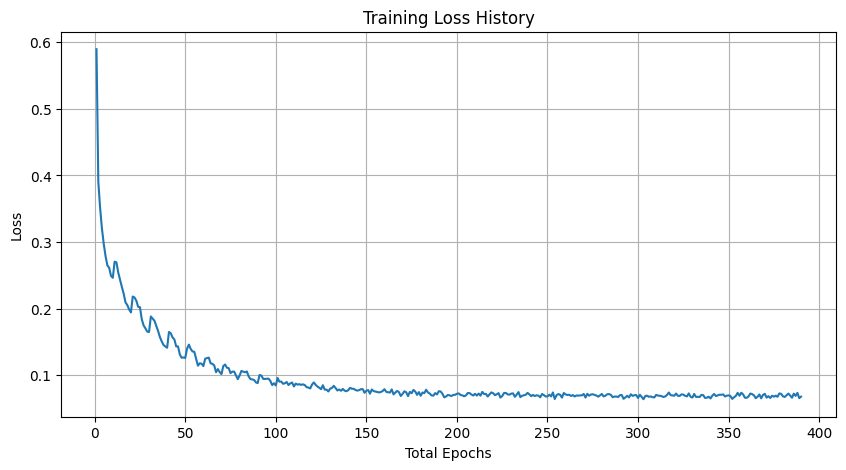

Best result: 0.8915 at iteration 7
Prediction saved to y_pred_20250805_232256.csv


In [ ]:
plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")